In [17]:
import torch
import dlc_practical_prologue as prologue
import numpy as np

print('libraries imported')

libraries imported


In [18]:
train_input, train_target, test_input, test_target = prologue.load_data()

print('train_input', train_input.size(), 'train_target', train_target.size())
print('test_input', test_input.size(), 'test_target', test_target.size())

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples
train_input torch.Size([1000, 784]) train_target torch.Size([1000])
test_input torch.Size([1000, 784]) test_target torch.Size([1000])


In [19]:
import matplotlib.pyplot as plt

def display_mnist_tensor(x, title: str):
    n = int(np.sqrt(x.shape[1])) 
    plt.title(title)
    plt.imshow(x.numpy().reshape(n, n), cmap="copper") 

#### Nearest Neighbour

The first algorithm implemented is the **1-Nearest Neighbours** to compute the distances between the training set and the testing set and set the label as according to the minimum of the **L2 Norm** distances: $argmin \sum_n min_k ||y_i - x_n||^2 $ for each testing point $y_i, i = \{1, ..., len(y)\}$. 

In our case, we only have one neighbour so $k = 1$.

In [20]:
def error_rate(model_target, test_target):
    return torch.sum(model_target != test_target).item() / len(test_target)


def nearest_classification(x_train, x_label, y_test):
    final_output = []
    for y in y_test:
        squared_distances = torch.sum(torch.pow(torch.sub(y, x_train), 2), 1).sqrt()
        indices = torch.argmin(squared_distances)
        output = x_label[indices]
        final_output.append(output)
    return torch.tensor(final_output)

l2_nn_output = nearest_classification(train_input, train_target, test_input)
print('Error rate for L2 Norm 1-Nearest-Neighbour is: {}%'.format(error_rate(l2_nn_output, test_target) * 100))

Error rate for L2 Norm 1-Nearest-Neighbour is: 17.2%


Another version of the *Nearest Neighbour* algorithm however implemented a bit differently by taking two for loops. It takes $20x$ longer to execute however it gives a lower error rate (might be an implementation fault).

In [21]:
def nearest_classification_2(x_train, x_label, y_test):
    final_output = []
    for i in range(len(y_test)):
        distance = [torch.sum(torch.pow(torch.sub(y_test[i], x_train[j]), 2)).sqrt() for j in range(len(x_train))]
        test_predicted = x_label[np.argmin(distance)]
        final_output.append(test_predicted)
    return np.asarray(final_output)

output2 = nearest_classification_2(train_input, train_target, test_input)
print('Error - For Loop Element by Element Method: {}%'.format((float(np.sum(output2 != test_target)) / len(output2)) * 100))

Error - For Loop Element by Element Method: 0.1%


#### Error Estimation

The same distances and errors as the previous example will be performed however with the introduction of *mean*, a 1d float tensor of dimension $d$ (our train vectors are $n \times d$), and *proj*, a 2d float tensor of dimension $c \times d$.

*mean* $\rArr$ generated as a tensor filled with the constant float value $\mu$, a parameter decided by the user.

*proj* $\rArr$ generated as a float tensor with uniformly distributed values from a custom interval $[r_1, r_2]$ .

Both our training and testing sets of data will be subtracted with the *mean* vector, and a matrix multiplication will happen with the *proj* matrix, in order to compare the effect it will have on the error rates.

In [22]:
def compute_nb_errors(train_input, train_target, test_input, test_target, mean = None, proj = None): 
    if mean != None:
        mean_tensor = torch.full((1, train_input.shape[1]), mean)
        
        test_input = torch.sub(test_input, mean_tensor)
        train_input = torch.sub(train_input, mean_tensor)
        
        ## Change the negative values back to 0 using reLU
        test_input = torch.nn.functional.relu(test_input)
        train_input = torch.nn.functional.relu(train_input)
        
        output1 = nearest_classification(train_input, train_target, test_input)
        error1 = error_rate(output1, test_target)
    
    if proj != None:
        ## Torch Matrix Multiplication
        test_input = torch.mm(test_input, proj)
        train_input = torch.mm(train_input, proj)
        
        output2 = nearest_classification(train_input, train_target, test_input)
        error2 = error_rate(output2, test_target)
    
    return error1, error2 


mean = 25
c = 126 ## size of the dimension of the proj matrix (d x c)
r1 = 1.5
r2 = 5
proj_example = torch.FloatTensor(train_input.shape[1], c).uniform_(r1, r2)


second_output, third_output = compute_nb_errors(train_input, train_target, test_input, test_target, mean = mean, proj = proj_example)

print('Error rate for L2 Norm 1-Nearest-Neighbour after Mean Subtraction is: {}%'.format(second_output * 100))
print('Error rate for L2 Norm 1-Nearest-Neighbour after Projection Multiplication is: {}%'.format(third_output * 100))

Error rate for L2 Norm 1-Nearest-Neighbour after Mean Subtraction is: 18.2%
Error rate for L2 Norm 1-Nearest-Neighbour after Projection Multiplication is: 52.400000000000006%


#### PCA

The other technique we will apply to our dataset is the *Principal Component Analysis* used for dimension reduction in order to increase the interpretability. Below is an implemented version of PCA by taking advantage of its relationship with *Singular Value Decomposition* such as:

$A = U \Sigma V^T$ for any matrix A. Where we know that the right singular vector $V$ is the **eigenvector** of the covariance matrix while the **eigenvalues** are hidden in the singular values $\sigma$ of the diagonal matrix $\Sigma$, two arguments that we require in order to perform PCA and get the principal components based on maximized variance.

Using *PyTorch*, the SVD of the matrix can be found using **torch.linalg.svd(x)**

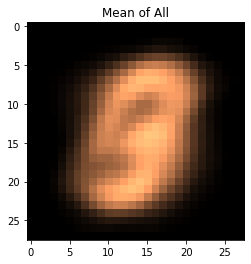

In [23]:
def PCA_with_SVD(x, k):
    ## A) Compute the mean and center the data
    mu = torch.mean(x, 0, True) ## 1D Vector of Mean (dimension D, number of columns)
    data_for_pca = torch.sub(x, mu)
    
    ## Singular Value Decomposition - Eigenvector is the transpose of the right singular vector (v_t)
    u, s, v_t = torch.linalg.svd(data_for_pca)
    pca_basis = v_t.t()[:, :k]
    return mu, pca_basis

number_of_components = train_input.shape[1] ## hardcoded to full components at the moment (dimension d)
mean, eigvectors = PCA_with_SVD(train_input, number_of_components)

# If Used Data is Tensor
display_mnist_tensor(mean, 'Mean of All')

In [24]:
## Projections of original observation onto new vector form
z = torch.mm(train_input, eigvectors)
l2_nn_output_after_pca = nearest_classification(z, train_target, test_input)
print('Error rate for L2 Norm 1-Nearest-Neighbour after PCA is: {}%'.format(error_rate(l2_nn_output_after_pca, test_target) * 100))

Error rate for L2 Norm 1-Nearest-Neighbour after PCA is: 87.4%


#### MNIST vs CIFAR

The first observable difference regarding the performance of the algorithms between the two different datasets (**CIFAR-10** and **MNIST**) is the lower accuracy levels of *1-NN* when the **CIFAR-10** dataset is concerned. This is simply understandable from the fact that the images contained in this dataset are of a more complex structure on a pixel level. Consequently, the fact that two images who have a similar structure and mean of all pixels between them (on a block level) can easily be part of different classes of classification (one dog and one cat), leads to a higher level of the above mentioned error.

On the contrary, in **MNIST**, structures and values of pixels (except the flat areas that make up the background) are usually a good indicator of what the number on the image is (the labels $0-9$), therefore the *1-NN* performs better automatically.

Regarding the *Error Estimation* task of this practical, I can say that the subtraction of the mean and the projection of the data doesn't have a distinct effect on the accuracy overall.